# Лабораторная работа № 3. Методы классификации данных
### Степушин С.В. 19-ИВТ-2
### Вариатн - 6
#### Классификаторы - 1,4
### 1.	Изучить набор данных. Создать описание набора данных на русском языке. 

#### Набор данных:

date: дата (год - месяц - день - час : минута : секунда)

Temperature: температура (по Цельсию)

Humidity: относительная влажность (в процентах)

Light: освещенность (в люксах)

CO2: углекислый газ (в ppm)

HumidityRatio: коэфицент влажности (производная от температуры и относительной влажности приходящихся на 1 кг водянного пара / воздуха)

Occupancy: занятность (0 - незанятый статус, 1 - занятый статус)

### 2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции.

In [28]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import (auc, roc_curve, precision_recall_curve, average_precision_score)
occupancy = pd.read_csv('datatraining.csv')
print("Количество строк до очистки:" , len(occupancy))
print("Количество строк после очистки:" , len(occupancy.drop_duplicates()))

Количество строк до очистки: 8143
Количество строк после очистки: 8143


### 3.	Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая).

<AxesSubplot:>

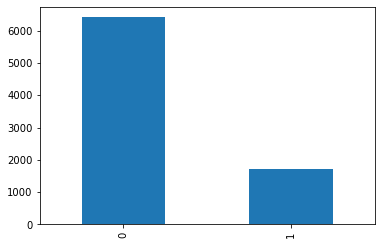

In [2]:
occupancy['Occupancy'].value_counts().plot.bar()

Видно, что классы не сбалансированны, поэтому будем использовать ROC-кривую.

### 4.Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию).

Диаграммы BoxPlot до мастштабирования:


<AxesSubplot:>

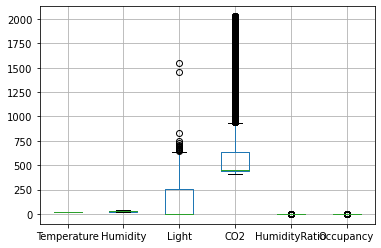

In [3]:
print('Диаграммы BoxPlot до мастштабирования:')
occupancy.boxplot()

Теперь нужно отделить числовые признаки от категориальных, но не учитывая первый и последний столбец ( первый - дата и время, а последний - класс).

In [4]:
from sklearn.preprocessing import MinMaxScaler
numerical_columns = [i for i in occupancy.columns[1:6] if occupancy[i].dtype.name != 'object']
categorial_columns = [i for i in occupancy.columns[1:6] if occupancy[i].dtype.name == 'object']
print("Числовые: ", numerical_columns)
print("Категориальные : ", categorial_columns)

Числовые:  ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
Категориальные :  []


Как видим у нас остались только числовые признаки. Так как один из классификаторов будет метод k ближайших соседей, то следует делать нормализацию признаков.

In [5]:
normal = MinMaxScaler()
occupancy[numerical_columns] = normal.fit_transform(occupancy[numerical_columns])
occupancy.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,0.557318,1
2,2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,0.554807,1
3,2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,0.553761,1
4,2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,0.551669,1
5,2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,0.547851,1


Диаграммы BoxPlot после мастштабирования:


<AxesSubplot:>

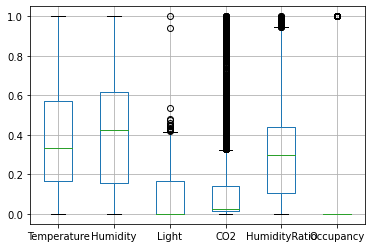

In [6]:
print('Диаграммы BoxPlot после мастштабирования:')
occupancy.boxplot()

### 5.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены
В нашем случае замена не нужна, потому что категориальные признаки отсутствуют.

### 6.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации).

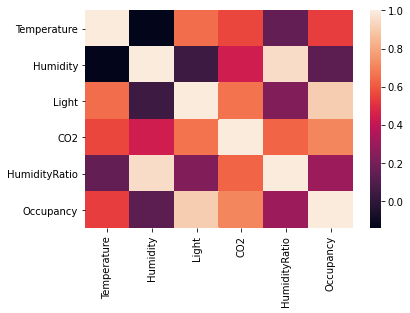

In [7]:
import seaborn as sns
sns.heatmap(occupancy.corr());

In [8]:
occupancy.corr()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762,0.538220
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198,0.132964
Light,0.649942,0.037828,1.000000,0.664022,0.230420,0.907352
CO2,0.559894,0.439023,0.664022,1.000000,0.626556,0.712235
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000,0.300282
Occupancy,0.538220,0.132964,0.907352,0.712235,0.300282,1.000000


### 7.	Заполните пропущенные значения в данных.

In [9]:
print("Количество строк:" , len(occupancy))

Количество строк: 8143


Теперь посмотрим есть ли пропущенные значения.

In [10]:
occupancy.count()

date             8143
Temperature      8143
Humidity         8143
Light            8143
CO2              8143
HumidityRatio    8143
Occupancy        8143
dtype: int64

Пропущенных значений нет.

### 8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию. 

1 – классификатор K ближайших соседей (задаётся количество ближайших объектов);
4 – логический классификатор (бинарное решающее дерево).
#### Загрузим тестовую выборку

In [11]:
occupancy_test = pd.read_csv('datatest2.csv')
occupancy_test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


#### Проведем нормализацию.

In [12]:
numerical_columns = [i for i in occupancy_test.columns[1:6] if occupancy_test[i].dtype.name != 'object']
categorial_columns = [i for i in occupancy_test.columns[1:6] if occupancy_test[i].dtype.name == 'object']
normal = MinMaxScaler()
occupancy_test[numerical_columns] = normal.fit_transform(occupancy_test[numerical_columns])
occupancy_test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,0.462168,0.525565,0.276618,0.342373,0.700223,1
2,2015-02-11 14:49:00,0.468303,0.518004,0.276618,0.323736,0.695239,1
3,2015-02-11 14:50:00,0.463701,0.524950,0.274510,0.326092,0.700447,1
4,2015-02-11 14:51:00,0.463701,0.524950,0.277672,0.329704,0.700447,1
5,2015-02-11 14:51:59,0.468303,0.525565,0.276618,0.327296,0.703947,1


<AxesSubplot:>

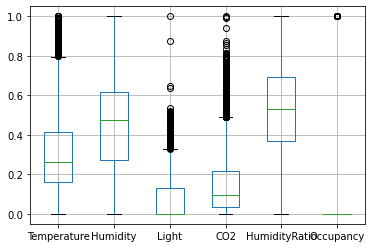

In [13]:
occupancy_test.boxplot()

#### Проверим есть ли пропущнные данные.

In [14]:
print("Количество строк:" , len(occupancy_test))
occupancy_test.count()

Количество строк: 9752


date             9752
Temperature      9752
Humidity         9752
Light            9752
CO2              9752
HumidityRatio    9752
Occupancy        9752
dtype: int64

Как видно пропущенных данных нет.

#### Метод k ближайших соседей.

In [15]:
x, y = occupancy[numerical_columns + ['Occupancy']].drop('Occupancy', axis=1), occupancy['Occupancy']
x_test, y_test = occupancy_test[numerical_columns + ['Occupancy']].drop('Occupancy', axis=1), occupancy_test['Occupancy']

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
KNS = KNeighborsClassifier()
search = GridSearchCV(KNS, {'n_neighbors': range (1,50)})
search.fit(x, y)
selected_n_neighbors = search.best_estimator_.n_neighbors
print('Лучший результат: ', search.best_score_)

KNS = KNeighborsClassifier(n_neighbors=selected_n_neighbors)
KNS.fit(x, y)
best_score  = np.mean(y_test  == KNS.predict(x_test))
print('Результат тест: ', best_score)

Лучший результат:  0.9328218726008781
Результат тест:  0.9487284659557014


#### Логический классификатор(бинарное решающее дерево)

In [17]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
search = GridSearchCV(DTC, {'max_depth': list(range(1, 6)), 'max_features': list(range(1, 6))})
search.fit (x, y)
best_depth = search.best_estimator_.max_depth
best_features = search.best_estimator_.max_features
print('Лучший результат: ', search.best_score_)

DTC = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
DTC.fit(x, y)
best_score = np.mean(y_test == DTC.predict(x_test))
print('Результат тест: ', best_score)

Лучший результат:  0.9818285890109095
Результат тест:  0.9934372436423298


#### PR-кривая

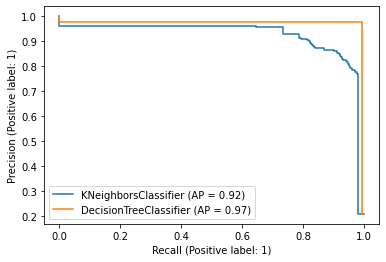

In [18]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
i = plot_precision_recall_curve(KNS, x_test, y_test)
g = plot_precision_recall_curve(DTC, x_test, y_test, ax = i.ax_)

#### ROC-кривая

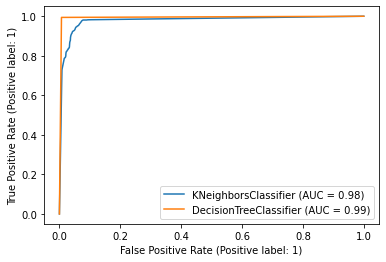

In [19]:
i = plot_roc_curve(KNS, x_test, y_test)
g = plot_roc_curve(DTC, x_test, y_test, ax = i.ax_)

### 9.	Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

Линейный классификатор(бинарное решающее дерево) имеет лучше показатели качества, чем метод k ближайших соседей.